In [1]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lalsimulation
import lal
import numpy as np

import matplotlib.pyplot as plt
from scipy.interpolate import interp1d


from pycbc.types import TimeSeries

import sys
import os

import waveform
import gw_utils

from likelihood.relative_binning import RelativeBinningLikelihood, BaseRelativeBinning
import data

In [2]:
import pycbc
import pycbc.waveform as waveform
from pycbc.waveform import get_fd_waveform
from pycbc.detector import Detector


# Define parameters for the waveform
params = {
    'mass1': 1.4,                   
    'mass2': 1.4,                   
    'spin1z': 0.0,                 
    'spin2z': 0.0,                
    'distance': 400,               
    'inclination': 0.0,            
    'f_ref': 0,                    
    'f_lower': 2,                  
    'f_final': 32,                 
    'approximant': 'IMRPhenomD' 
}

ra = 0  
dec = 0  
polarization = 0  
geocent_time = 1126259462.4
detector = Detector('H1')

hp_time_windowed, hc_time_windowed = waveform.get_td_waveform(delta_t=1/64, **params)

# Project the strain onto the detector
projected_strain_pycbc_const = detector.project_wave(hp_time_windowed, hc_time_windowed, ra, dec, polarization, method='constant')
projected_strain_pycbc_vp = detector.project_wave(hp_time_windowed, hc_time_windowed, ra, dec, polarization, method='vary_polarization')

# Convert the projected strain back to the frequency domain
projected_strain_pycbc_const_fd = projected_strain_pycbc_const.to_frequencyseries()
projected_strain_pycbc_vp_fd = projected_strain_pycbc_vp.to_frequencyseries()

frequencies = projected_strain_pycbc_const_fd.get_sample_frequencies().data



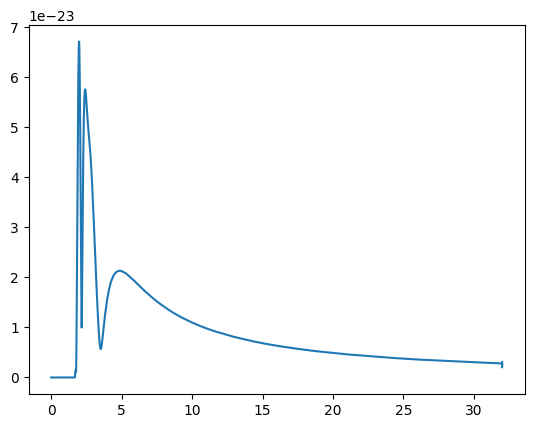

In [3]:
plt.plot(frequencies, np.abs(projected_strain_pycbc_vp_fd))

In [4]:
eventname, mchirp_guess = 'GW150914', 30
approximant = 'IMRPhenomD'
prior_class = 'CartesianIntrinsicIASPrior'

filenames, detector_names, tgps = data.download_timeseries(eventname)

event_data = data.EventData.from_timeseries(
    filenames, eventname, detector_names, tgps)

Skipping existing file /Users/jackson/Desktop/ucsb/cogwheel/my_cogwheel/cogwheel/data/gwosc_files/GW150914/H_GW150914.hdf5
Skipping existing file /Users/jackson/Desktop/ucsb/cogwheel/my_cogwheel/cogwheel/data/gwosc_files/GW150914/L_GW150914.hdf5


In [5]:
from gw_utils import fplus_fcross
from waveform import WaveformGenerator

detector_names = event_data.detector_names
tgps = event_data.tgps
tcoarse = event_data.tcoarse
harmonic_modes = [(2, 2)]
disable_precession = False
n_cached_waveforms = 1
lalsimulation_commands = ()

wg = WaveformGenerator(detector_names, tgps, tcoarse, approximant,
                                       harmonic_modes=harmonic_modes,
                                       disable_precession=disable_precession,
                                       n_cached_waveforms=n_cached_waveforms,
                                       lalsimulation_commands=lalsimulation_commands)


In [6]:
params_dic = {
    'ra': 0,
    'dec': 0,
    't_geocenter': 1126259462.4,
    'psi': 0,
    'phi_ref': 0.0,                 # Phase at reference frequency (radians)
    'm1': 1.4,                    # Mass of the first object (in Msun)
    'm2': 1.4,                    # Mass of the second object (in Msun)
    'l1': 0,
    'l2': 0,
    's1x_n': 0.0,                     # Spin component of the first object (x-axis)
    's1y_n': 0.0,                     # Spin component of the first object (y-axis)
    's1z': 0.0,                     # Spin component of the first object (z-axis)
    's2x_n': 0.0,                     # Spin component of the second object (x-axis)
    's2y_n': 0.0,                     # Spin component of the second object (y-axis)
    's2z': 0.0,                     # Spin component of the second object (z-axis)
    'f_ref': 0,                 # Reference frequency (Hz)
    'd_luminosity': 400,            # Luminosity distance (meters)
    'iota': 0.0,                    # Inclination angle (radians)
    'lal_dic': lal.CreateDict(),    # LAL dictionary for additional parameters
}

f = event_data.frequencies
hp_cogwheel, hc_cogwheel = wg.get_hplus_hcross(f, params_dic, by_m = False)

mask = np.logical_and(f>=2, f <= 31)

In [7]:
%%prun
strain_0 = wg.get_strain_at_detectors(f, params_dic)

         85 function calls in 0.019 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.010    0.010    0.011    0.011 waveform.py:642(_get_shifts)
        3    0.004    0.001    0.004    0.001 {built-in method numpy.core._multiarray_umath.c_einsum}
        1    0.001    0.001    0.002    0.002 waveform.py:676(get_hplus_hcross)
        1    0.001    0.001    0.001    0.001 {built-in method lal._lal.GreenwichMeanSiderealTime}
        2    0.001    0.000    0.001    0.000 {built-in method lal._lal.ComputeDetAMResponse}
        2    0.001    0.000    0.001    0.000 {method 'reduce' of 'numpy.ufunc' objects}
        2    0.001    0.000    0.001    0.000 numeric.py:2378(array_equal)
        1    0.000    0.000    0.019    0.019 waveform.py:527(get_strain_at_detectors)
        1    0.000    0.000    0.001    0.001 gw_utils.py:77(get_geocenter_delays)
        1    0.000    0.000    0.019    0.019 <string>:1(<module>)
  

In [8]:
%%prun
strain_1 = wg.get_strain_at_detectors(f[mask], params_dic, vary_polarization=True, doppler=False, use_cached=True)

         397403 function calls in 0.495 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        3    0.070    0.023    0.070    0.023 {built-in method lalsimulation._lalsimulation.SimInspiralChooseFDWaveformSequence}
    14865    0.057    0.000    0.057    0.000 {method 'reduce' of 'numpy.ufunc' objects}
        3    0.037    0.012    0.119    0.040 waveform.py:34(compute_hplus_hcross)
     7428    0.035    0.000    0.060    0.000 numeric.py:932(tensordot)
    22284    0.028    0.000    0.033    0.000 numeric.py:841(outer)
        1    0.022    0.022    0.306    0.306 waveform.py:813(time_series)
     3714    0.020    0.000    0.045    0.000 frequency_dependent_response.py:46(get_polarization_tensor1)
        2    0.018    0.009    0.018    0.009 function_base.py:1606(angle)
        2    0.018    0.009    0.032    0.016 function_base.py:1663(unwrap)
     3714    0.017    0.000    0.055    0.000 frequency_dependent_response.

In [9]:
%%prun
strain_2 = wg.get_strain_at_detectors(f[mask], params_dic, vary_polarization = True, doppler = True, use_cached=True)

         27962 function calls in 0.042 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     1857    0.013    0.000    0.021    0.000 gw_utils.py:77(get_geocenter_delays)
     1857    0.006    0.000    0.006    0.000 gw_utils.py:92(tgps_to_gmst)
     3718    0.004    0.000    0.004    0.000 {built-in method numpy.array}
     1859    0.003    0.000    0.003    0.000 {built-in method numpy.core._multiarray_umath.c_einsum}
        1    0.002    0.002    0.030    0.030 waveform.py:642(_get_shifts)
        1    0.002    0.002    0.042    0.042 <string>:1(<module>)
        1    0.001    0.001    0.006    0.006 waveform.py:148(<dictcomp>)
        1    0.001    0.001    0.001    0.001 {built-in method lal._lal.CreateDict}
        1    0.001    0.001    0.001    0.001 {built-in method lalsimulation._lalsimulation.SimInspiralChooseFDWaveformSequence}
        1    0.001    0.001    0.005    0.005 waveform.py:34(compute_hplus_hcross)
  

In [10]:
%%prun
strain_3 = wg.get_strain_at_detectors(f[mask], params_dic, vary_polarization = False, doppler = True, use_cached=True)

         61 function calls in 0.002 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.001    0.001    0.002    0.002 <string>:1(<module>)
        2    0.001    0.000    0.001    0.000 {built-in method numpy.core._multiarray_umath.c_einsum}
        1    0.000    0.000    0.002    0.002 {built-in method builtins.exec}
        3    0.000    0.000    0.000    0.000 {method 'reduce' of 'numpy.ufunc' objects}
        1    0.000    0.000    0.000    0.000 waveform.py:676(get_hplus_hcross)
        2    0.000    0.000    0.000    0.000 numeric.py:2378(array_equal)
        1    0.000    0.000    0.000    0.000 waveform.py:755(_matching_cache)
        1    0.000    0.000    0.001    0.001 waveform.py:527(get_strain_at_detectors)
        1    0.000    0.000    0.000    0.000 linalg.py:2383(norm)
        1    0.000    0.000    0.001    0.001 waveform.py:605(get_hplus_hcross_at_detectors)
        1    0.000    0.000    0.000

In [11]:
# mask1 = np.logical_and(frequencies >= 2, frequencies <= 31)
# plt.figure(figsize=(10, 6))
# plt.plot(f[mask], abs(strain_1[0]), label='vp_cogwheel', color='blue', linestyle='-', linewidth=1.5)
# plt.plot(frequencies[mask1], abs(projected_strain_pycbc_vp_fd[mask1]), label='vp_pycbc', color='orange', linestyle='--', linewidth=1.5)
# #plt.plot(frequencies, abs(projected_strain_pycbc_const_fd), label='const_pycbc', color='cyan', linestyle=':', linewidth=1.5)
# #plt.plot(f, abs(strain_0[0]), label='const_cogwheel', color='magenta', linestyle='dotted', linewidth=1.5)


# plt.xlabel('Frequency (Hz)', fontsize=14)
# plt.ylabel('Strain Amplitude', fontsize=14)
# plt.title('Comparison of Strain at Detectors', fontsize=16)

# plt.grid(True, which='both', linestyle='--', linewidth=0.5)
# plt.legend()
# plt.savefig('Strain_Signal_Comparison.pdf')
# plt.show()
hp_time_windowed.start_time += geocent_time
hc_time_windowed.start_time += geocent_time


In [ ]:


projected_strain_pycbc_lal = detector.project_wave(
    hp_time_windowed, hc_time_windowed, ra, dec, polarization, method='lal')

projected_strain_pycbc_lal_fd = projected_strain_pycbc_lal.to_frequencyseries()

freq_lal = projected_strain_pycbc_lal_fd.get_sample_frequencies()

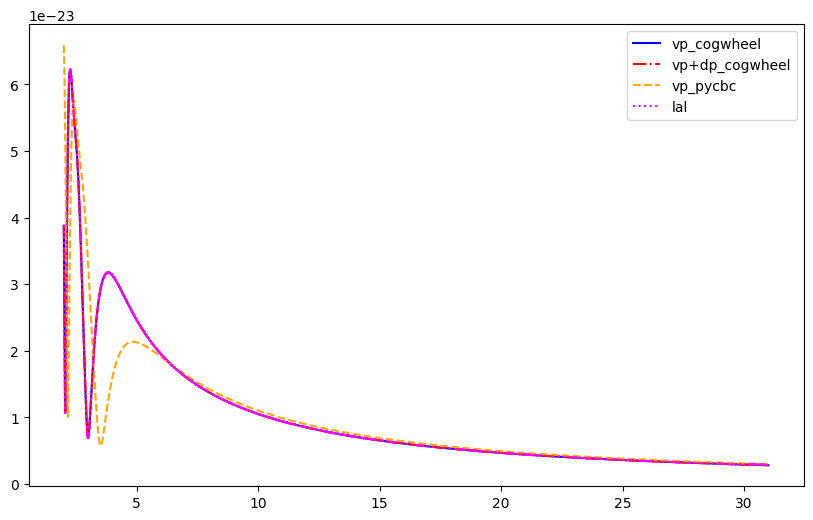

In [13]:
mask1 = np.logical_and(frequencies >= 2, frequencies <= 31)
mask2 = np.logical_and(freq_lal >= 2, freq_lal <= 31)

plt.figure(figsize=(10, 6))
plt.plot(f[mask], abs(strain_1[0]), label='vp_cogwheel', color='blue', linestyle='-', linewidth=1.5)
plt.plot(f[mask], abs(strain_2[0]), label='vp+dp_cogwheel', color='red', linestyle='-.', linewidth=1.5)
plt.plot(frequencies[mask1], abs(projected_strain_pycbc_vp_fd[mask1]), label='vp_pycbc', color='orange', linestyle='--', linewidth=1.5)
plt.plot(freq_lal[mask2], np.abs(projected_strain_pycbc_lal_fd[mask2]), label = 'lal', color = 'magenta', linestyle = 'dotted', linewidth = 1.5)
plt.legend()

In [ ]:
rbl = RelativeBinningLikelihood(
    event_data=event_data,
    waveform_generator=wg,
    par_dic_0=params_dic,
    fbin=f, 
)